# Assignment 3 - Ridge and Lasso Regression 

### We are going to predict baseball salaries from performance data.  

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


The task in this assignment is to build models of Baseball players (only fielding players, not pitchers) salaries based on statistics.  These are real data from MLB.  
Why is this an important task - if you are a player learn what gets you paid! 
I did a little bit of clean up of the csv as we read it in. 

In [2]:
df = pd.read_csv('Hitters.csv', index_col=0)
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

The first 7 variables are from the previous season.  The variables starting with a C are career statistics.  PutOuts, Assists, and Errors are also single season statistics.  Salary is their salary.  League, Division, and NewLeague reflect where they play. 

Always deal with problems.  Non-null count tells you how many entries you have that are not missing values.  `Salary` clearly shows missing values. 

In [3]:
#Lets preemptively get rid of garbage. 
df=df.dropna()
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [5]:
print(df.columns)

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')


1.  Encode and organize the data

There are 4 variables that are objects, i.e., string -  League, Division, and NewLeague.   You need to convert these into numeric variables, for example by using `get_dummies`.  

Take a moment to look at the values contained in each of these, and then make a strategy of how you want to encode them.  Keep in mind that each of them takes only two values, and you dont want to create variables that are redundant.  

NewLeague indicates the team the league is in for the new season.  Very few players change leagues, so there is not much information there.  You should remove it from the dataframe, and I assumed you did in the rest of this assignment.

The response variable is Salary.  The other variables are your predictors.  

In [6]:
# first remove NewLeague column
df = df.drop(columns=['NewLeague'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AtBat     263 non-null    int64  
 1   Hits      263 non-null    int64  
 2   HmRun     263 non-null    int64  
 3   Runs      263 non-null    int64  
 4   RBI       263 non-null    int64  
 5   Walks     263 non-null    int64  
 6   Years     263 non-null    int64  
 7   CAtBat    263 non-null    int64  
 8   CHits     263 non-null    int64  
 9   CHmRun    263 non-null    int64  
 10  CRuns     263 non-null    int64  
 11  CRBI      263 non-null    int64  
 12  CWalks    263 non-null    int64  
 13  League    263 non-null    object 
 14  Division  263 non-null    object 
 15  PutOuts   263 non-null    int64  
 16  Assists   263 non-null    int64  
 17  Errors    263 non-null    int64  
 18  Salary    263 non-null    float64
dtypes: float64(1), int64(16), object(2)
memory usage: 41.1+

In [7]:
# Lets use get_dummies to do it. 
# NewLeague is gone, so time to convert League and Division into numeric columns 
categorical_cols = ['League', 'Division'] # var to hold categorical column names
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True) #
df_encoded.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,True,True
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,False,True
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,True,False
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,True,False
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,False,True


In [8]:
df_encoded.info() # confirming numeric conversion!

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AtBat       263 non-null    int64  
 1   Hits        263 non-null    int64  
 2   HmRun       263 non-null    int64  
 3   Runs        263 non-null    int64  
 4   RBI         263 non-null    int64  
 5   Walks       263 non-null    int64  
 6   Years       263 non-null    int64  
 7   CAtBat      263 non-null    int64  
 8   CHits       263 non-null    int64  
 9   CHmRun      263 non-null    int64  
 10  CRuns       263 non-null    int64  
 11  CRBI        263 non-null    int64  
 12  CWalks      263 non-null    int64  
 13  PutOuts     263 non-null    int64  
 14  Assists     263 non-null    int64  
 15  Errors      263 non-null    int64  
 16  Salary      263 non-null    float64
 17  League_N    263 non-null    bool   
 18  Division_W  263 non-null    bool   
dtypes: bool(2), f

2.  Its useful to do some exploratory data analysis.  
    First, visualize just the single season statistics. The first 7 columns in the dataframe from contain the single season statistics.  A pairplot would be a useful idea. You should immediately see that some of these variables are highly correlated. 

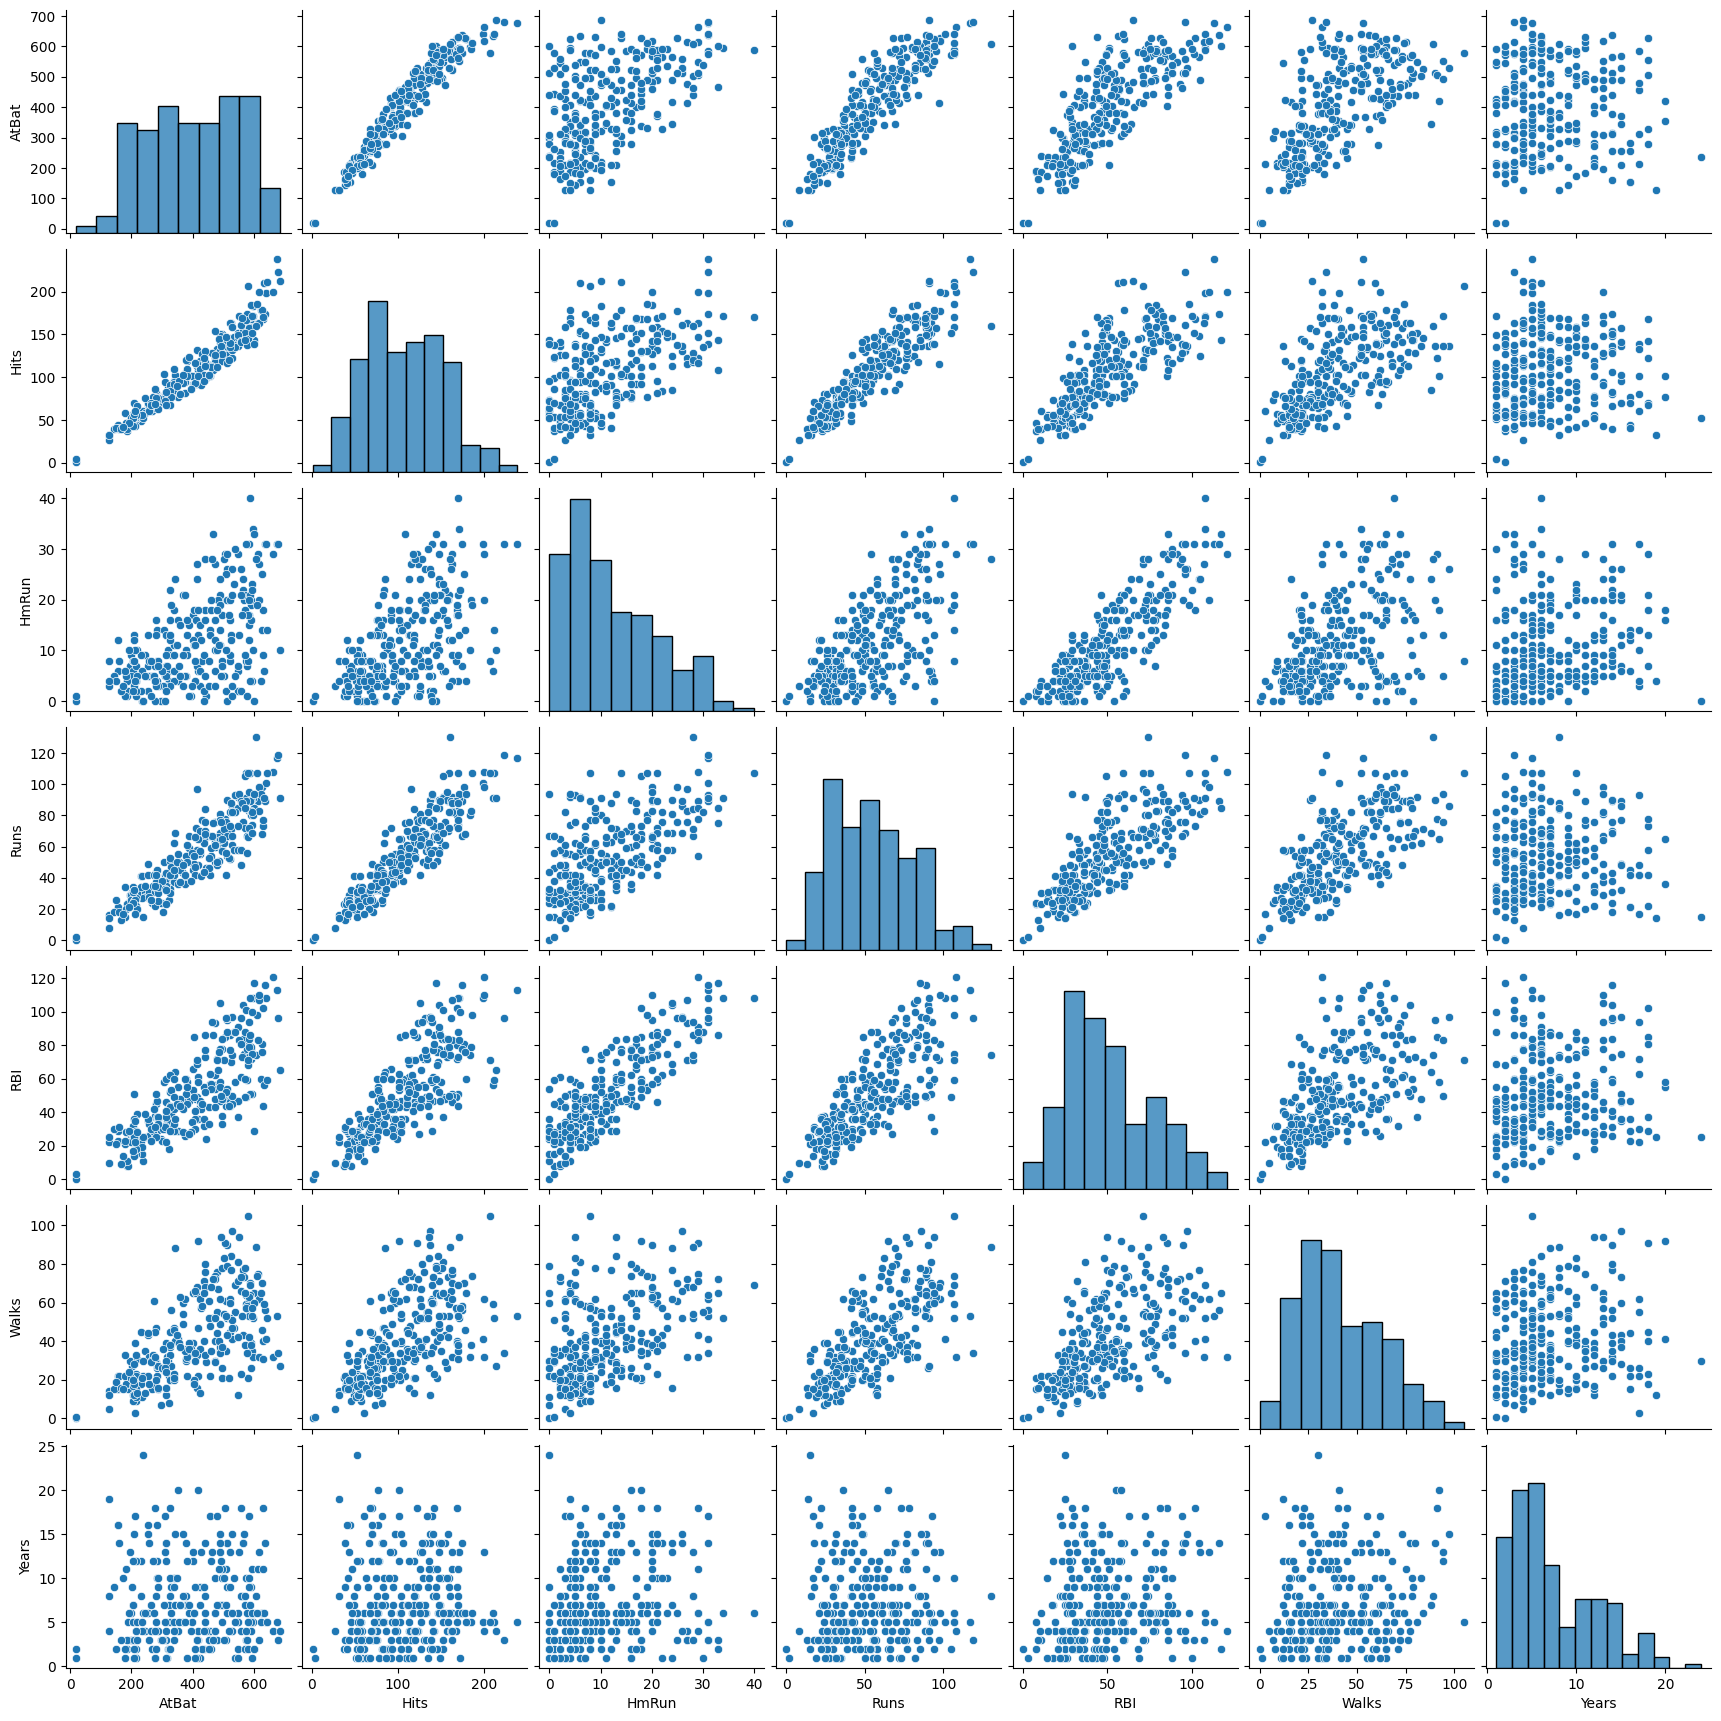

In [9]:
sns.pairplot(df_encoded, vars=['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years'])
plt.show()
# hue is salary because its the target variable we want to predict (predicting salary based on other features)
#sns.pairplot(heart, vars = ['Age','RestBP','Chol','MaxHR','Oldpeak'], hue = "AHD")

Make a heatmap showing the correlations between all the variables.  This will not work unless you have converted it all into dummy variables 

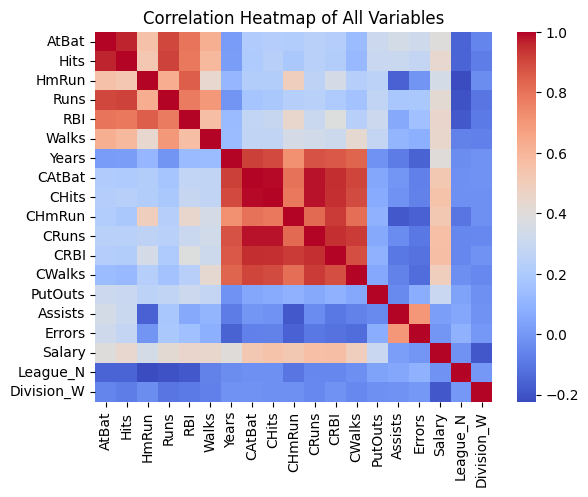

In [14]:
sns.heatmap(df_encoded.corr(), annot=False, cmap="coolwarm") # heatmap showing correlations with ALL variables
plt.title("Correlation Heatmap of All Variables")
plt.show()

Write down your impression of the data in the box below   What variables are highly correlated?  Are the single season statistics and career statistics highly correlated? What are some candidate variables that could explain salary? 

Those highly correlated are the first season statistics, specifically with AtBat x Hits, Atbat x Runs, and Hits x Runs. It seems like the variable RBI in the first season statistics, is still nicely correlated but not highly as the ones just mentioned. For the variable Years it is correlated nicely with career statistics. Most Career Statistics variables seem to be highly correlated with each other but when it comes to CHmRun, it is not as high but still moderately strong. Some candidate variables that can explain Salary are CHits, CRuns and CRBI based on the heat map correlations. The variables CAtBat, CHMRun, and CWalks can also help explain Salary but not as much as the ones just mentioned. 

3.  Separate the data into test (25%) and training sets.  Also separate the response variable (salary) into a separate variable y, and the predictors into a separate variable X.  Use StandardScaler to scale the predictors.   Whether you choose the scale the response variable is somewhat arbitrary.  If you dont, you will get a model that predicts actual salaries and has an intercept.  For this exercise lets do it that way. 

- Split the data into training and test sets 

In [ ]:
train_df, test_df = train_test_split(df_encoded, test_size=0.25, random_state=67)
features = df_encoded.columns.drop("Salary").tolist()

# pick the training and test data sets
X_train= 
X_test = np.array(X_test)
y_train = np.log(np.array(y_train))
y_test = np.log(np.array(y_test))

- Build a standard scaler model from the training set and apply to training and test sets.  

In [ ]:
scaler = StandardScaler().fit(X_train) # using StandardScaler to scale
# fit on training data, transform both training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make numpy matrices pandas dataframes
X_train_df = pd.DataFrame(X_train, columns=X)
X_test_df = pd.DataFrame(X_test, columns=X)

display(X_train_df.describe())
display(X_test_df.describe())



ValueError: Shape of passed values is (197, 18), indices imply (197, 263)

4.  Fit a model using OLS (`LinearRegression`).  Quantify how it fits the data in the test set by computing $r^2$.  Make a scatter plot showing the predicted salaries against the actual salaries in the test set. Make a bar plot showing the regression coefficients (`.coef_`) on each predictor. In the empty markdown box, write down how you would describe the model. 

R^2 for Linear Regression Model: 0.3301176740622992


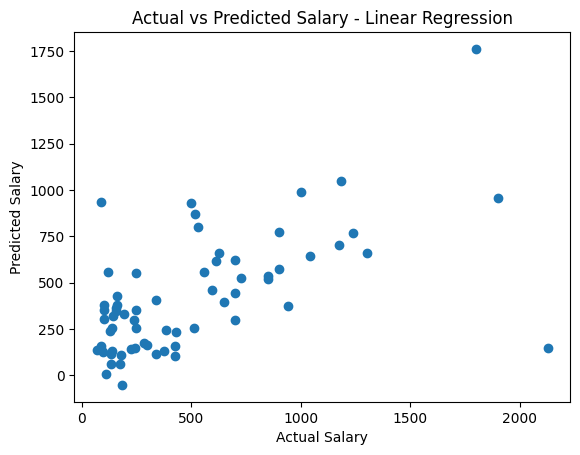

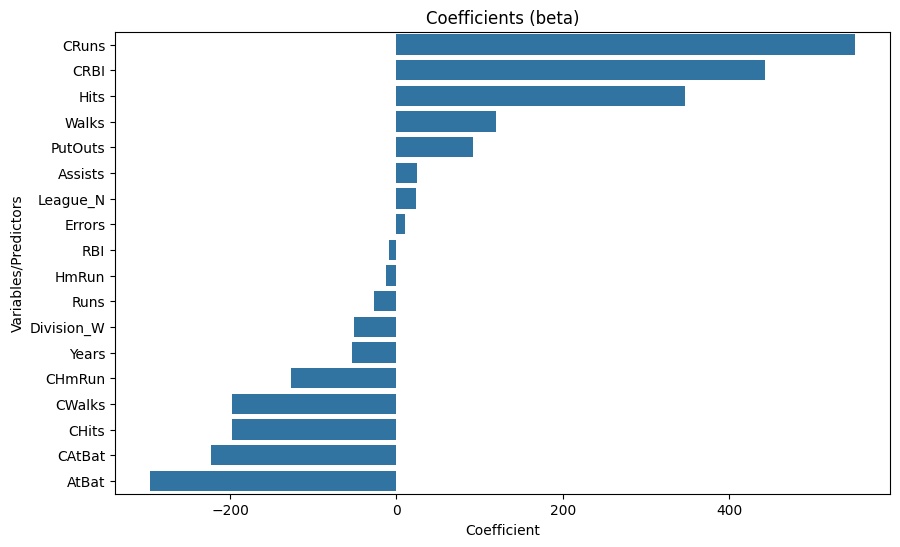

In [15]:
# fit the Linear Regression Model to the training data
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train) # fitting x training data scaled and y training predictor

# Predict Salary for test data
y_pred_linear = linear_reg.predict(X_test) # predicting the salary for the x test data that is scaled

# evaluate model performance by computing r^2
r2_lr = linear_reg.score(X_test, y_test) # r^2 score for test data
print(f"R^2 for Linear Regression Model: {r2_lr}") # print r^2 score

# scatterplot showing predicted salaries against the actual salaries in the test set
plt.scatter(y_test, y_pred_linear)    
plt.xlabel("Actual Salary") 
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary - Linear Regression")
plt.show()

# bar plot showing the coefficients of the Linear Regression Model
coef_df = pd.DataFrame({
    'Variables/Predictors': X.columns,
    'Coefficient': linear_reg.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x='Coefficient', y='Variables/Predictors')
plt.title("Coefficients (beta)")
plt.show()

For the model, the linear regression goal is to predict fielding player's salary based on the perfromance statistics and other categorical variables within the dataset. The model's r value is around 0.33, which aims to explain about 33% of the variance within salaries. This might mean that while performance statistics are related to a how much a player makes, there are also other factors at play that can be significant not within this model/data. (For ex. that can be contracts or reputation, fame)

## Multiple Linear Regression 

Discuss your results here.  What do you think are the most important predictors.  What does it mean if the $\beta$ is positive versus negative.  

For the actual vs predicted salaries scatter plot, it shows a nice general upward trend but with a bunch of scatter. This means that the model predictions are off from actual values for most players. The plot showss that the model at most only captures part of a relationship between perfromance and salary since it is showing a general trend, just not as precisely.  

The coefficient plot tells us the importance and the direction of each predictor/feature. Variables with the positive beta values, such as CRuns, CRBI, and Hits, have a positive association with salary. This means that if these predictors increase, salary tends to increase as well. Those with negative beta values (like AtBat, CAtBat, CHits, CWalks) have a negative association which means that if these are higher values for a player, it can be linked to having a lower salary. 

The most important predictors are CRuns, CRBI, and hits. These predictors are what teams might value the most when trying to determine how much a player can get paid. (ex: high career runs + hits == money money)

Positive $\beta$ means that increasing the predictor is increasing the outcome (salary). If $\beta$ is negative, increasing the predictor is decreasing the outcome of a high salary. 


5.  Fit a model using Ridge Regression with cross validation.
* The `RidgeCV()` function has an $\alpha$ argument that is $\lambda$ from the lecture notes used to tune the model.
* `RidgeCV()` requires a range of value of $\alpha$ to be specified. The selected $\alpha$ will make use of cross-validation.  
* $\alpha$  = 0 is equivalent to the Least Squares solution, but it is not recommended to you actually set $\alpha$ = 0 so avoid that.  
* We expect the coefficient estimates to be much smaller, in terms of $L_2$ norm, when a large value of $\alpha$ is used,
* A very large $\alpha$ has tiny coefficients and and the model is dominated by the intercept. 
* By default `RidgeCV()` performs generalized cross-validation(essentially Leave one-out CV),
* This can be changed using the argument `cv`.
        alphas = 10**np.linspace(5,-5,20)
        ridgecv = RidgeCV(alphas = alphas,cv = 5) # 5-fold cross validation
* the best value of alpha (over the range tested) is in `ridgecv.alpha_`
* Evaluate the model by predicting the test data  


In [16]:
# define range of alphas (lambda)
alphas = 10**np.linspace(5, -5, 20)

# create RidgeCV model with 5-fold CV
ridgecv = RidgeCV(alphas = alphas, cv = 5) # 5-fold cross validation

# fit to training data
ridgecv.fit(X_train, y_train)

# check best alpha
print("Best Alpha (Ridge)", ridgecv.alpha_)

# evaluate the r^2
r2_ridge = ridgecv.score(X_test, y_test)
print("R^2 for Ridge Model:", r2_ridge)

# predict on the test data
y_pred_ridge = ridgecv.predict(X_test)

Best Alpha (Ridge) 69.51927961775606
R^2 for Ridge Model: 0.31430629295972556


Make a scatter plot of the predicted salaries versus the actual salaries. Make a bar graph of the weights on the coefficients. 


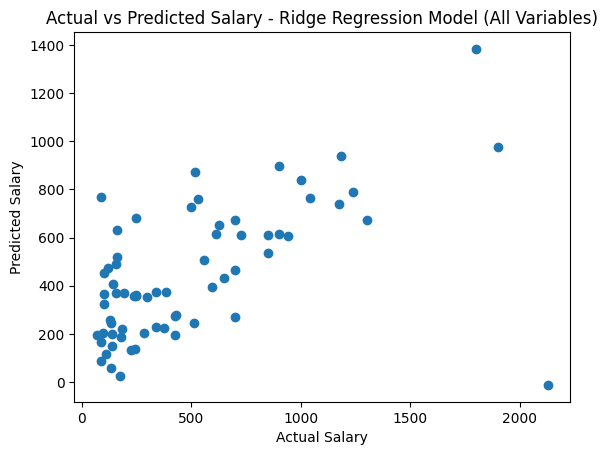

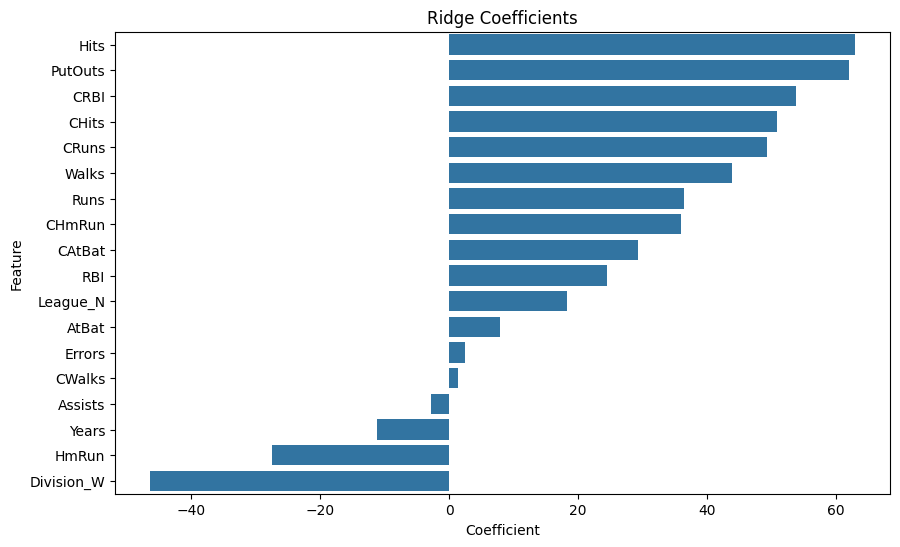

In [ ]:
# scatter plot
plt.scatter(y_test, y_pred_ridge)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary - Ridge Regression Model (All Variables)")
plt.show()

# bar graph
coef_ridge = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridgecv.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_ridge, x='Coefficient', y='Feature')
plt.title("Ridge Coefficients")
plt.show()

5.  Fit a model using LASSO Regression with cross validation. Use `LassoCV` with the same range of alpha values.  (This is not strictly required.  Typically you should test more small values of alpha)

In [18]:
# using the same range of alpha values 
# LassoCV model with 5-hold CV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)

# fit to scaled training data 
lasso_cv.fit(X_train, y_train)

# check best alpha 
print("Best Alpha by LassoCV:", lasso_cv.alpha_)

# evaluate r^2
r2_lasso = lasso_cv.score(X_test, y_test)
print("R^2 for Lasso Model:", r2_lasso)

# predict on test 
y_pred_lasso = lasso_cv.predict(X_test)

Best Alpha by LassoCV: 1.8329807108324374
R^2 for Lasso Model: 0.3254263395527003


Make a scatter plot of the predicted and actual values of salary.  Make a bar graph of the Lasso coefficients (some of them are zero)

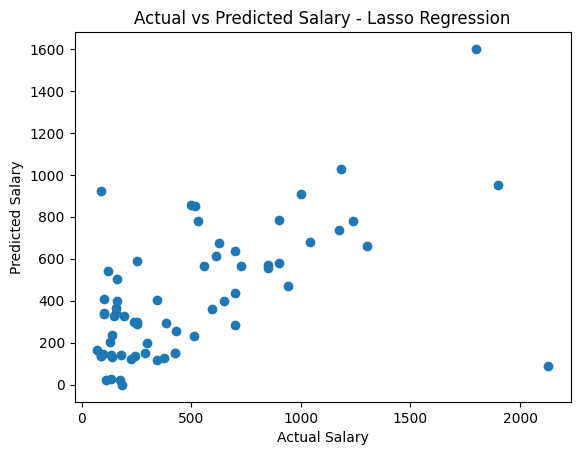

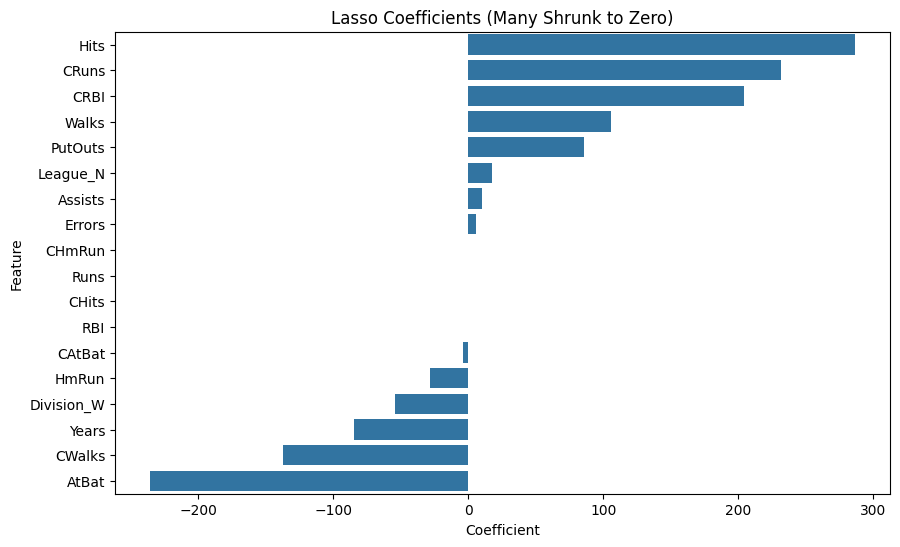

In [19]:
# scatter plot
plt.scatter(y_test, y_pred_lasso)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary - Lasso Regression")
plt.show()

# bar graph
coef_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_cv.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_lasso, x='Coefficient', y='Feature')
plt.title("Lasso Coefficients (Many Shrunk to Zero)")
plt.show()



6. I would like you to summarizethe results of this analysis, focusing on comparing Ridge and Lasso. 
    - How did they perform in prediction? is there a big difference?
    - What are the similarities in the pattern of coefficients selected? 
    - What are the differences? 
    - Does the correlation between the predictors have an effect on the two models?
    - Are there any surprising results in either model? 
    - Which model is easier to talk about?  
    - Is East Coast bias real? 

For the ridge regression, r^2 = 0.314 and in the lassso regression, r^2 was 0.325. Both of these models had performed very similiary but lasso perfromed slightly better with a minimal difference. This was also similiar to the linear regression model but neither of them improved over the linear model. This suggests that regularization did not change the model's ability to predict salary but it did affect the relationships of predictors and salaries. 

The similarities in the pattern of coefficients selected were that both of them identfied similar key predictors of salaries such as the Hits, CRuns, and CRBI's and PutOuts. Both show a negative coefficient for division_w, which may suggest that playing in the west division is associated with having lower salaries. However, the predictors are relatively the same for large salaries. 

For Ridge, the difference is that it keeps all variables within the model but shrinks coefficient smoothly toward zero without having to eliminate any of the variables. For the lasso regression, it performs with feature selections with some coefficients exactly zero such as CHmRun, Runs, CHits, and RBI. This means these predictors have been droped entirely. Lasso also seems to have a larger coefficient for variables compared to Ridge's smaller range. 

The correlation between the player statistics affect how models behave since ridge seems to distribute weight for the correlated variables (Hits, CRuns, CRBI, have general strength/very similiar) and lasso tends to select one variable from the correlated group (Hits) and then shrinks other variables sich as CRuns and CRBI. 

For the ridge model, I found it suprising that Division_W and Home runs had strongly negative coefficients since that mean those within the west or those who made a lot of home runs have lower predicted salaries. I also thought that valuable players scored more Home Runs, but maybe that is because I do not watch Baseball. For the lasso model, I found it surprising that AtBat was the largest negative coefficient (a batter's turn to hit), since it is related to hits when it is a player's turn but it might also explain losses at turn to hit. 

I also thought that the r values would be higher since these models are more detailed but it also might just mean that there are other factors like fame that can drive player salaries up. 

I think lasso was easier to interpret since it has a smaller set of predictors, dropping variables that are unimportant. Ridge had all the features, which can be harder to summarize but seems more stable. 

East Coast bias is real. This is seen in how Division_W was negative coefficients for both lasso and ridge, meaning that those in west divisions tends to have a low salary which supports the idea that the east coast bias is real. However, it may just mean that east coast teams are also paying more than those in the west since Baseball is not really a west coast sport. 

